In [1]:
from __future__ import annotations
from functools import partial
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '2'

import jax
import jax.numpy as jnp
import diffrax as dfx
import matplotlib.pyplot as plt
import numpy as np
from einops import rearrange

from check_shapes import check_shapes

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

import neural_diffusion_processes as ndp

In [2]:
from jax.config import config
config.update("jax_enable_x64", True)
JITTER = 1e-12

In [3]:
def get_2d_grid(num, min_=-1, max_=1):
    x = jnp.linspace(min_, max_, num)
    x1, x2 = jnp.meshgrid(x, x)
    x = jnp.stack([x1.flatten(), x2.flatten()], axis=-1)
    return x

(625, 2)


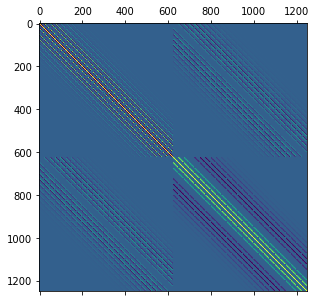

In [4]:

from jaxtyping import Array


class MultiOutputKernel:
    def __init__(self, kernel, output_dim: int):
        self.kernel = kernel
        self.output_dim = output_dim

    @check_shapes(
        "x: [input_dim]",
        "y: [input_dim]",
        "return: [output_dim, output_dim]",
    )
    def __call__(self, x, y):
        ...


class DiagMultiOutputKernel(MultiOutputKernel):

    @check_shapes(
        "x: [input_dim]",
        "y: [input_dim]",
        "return: [output_dim, output_dim]",
    )
    def __call__(self, x, y):
        return self.kernel(x, y) * jnp.eye(self.output_dim)



output_dim = 2
beta_schedule = ndp.sde.LinearBetaSchedule()
x = get_2d_grid(25)
k0 = ndp.kernels.SquaredExpontialKernel(lengthscale=0.25)
k0 = DiagMultiOutputKernel(k0, output_dim=output_dim)
k0 = ndp.kernels.RBFDivFree(lengthscale=.25)

k1 = ndp.kernels.WhiteKernel()
k1 = DiagMultiOutputKernel(k1, output_dim=output_dim)


class MultiOutputMeanFunction:
    def __init__(self, output_dim: int):
        self.output_dim = output_dim

    @check_shapes(
        "x: [input_dim]",
        "return: [output_dim]"
    )
    def __call__(self, x):
        ...
    
class ZeroMultiOutputMeanFunction(MultiOutputMeanFunction):

    @check_shapes(
        "x: [input_dim]",
        "return: [output_dim]"
    )
    def __call__(self, x):
        return jnp.zeros((self.output_dim,))
    
    
mean_function = ZeroMultiOutputMeanFunction(output_dim)

@check_shapes("x: [N, input_dim]", "return: [N, output_dim]")
def eval_meanfunction(mf: MultiOutputMeanFunction, x):
    return jax.vmap(lambda x_: mf.__call__(x_))(x)

from typing import Optional

@check_shapes(
    "x: [n1, input_dim]",
    "y: [n2, input_dim] if (y is not None)",
    "return: [n1, n2, output_dim, output_dim] if (y is not None)",
    "return: [n1, n1, output_dim, output_dim] if (y is None)" ,
)
def gram(kernel, x: Array, y: Optional[Array] = None) -> Array:
    y = x if (y is None) else y

    @partial(jax.vmap, in_axes=[0, None])
    @partial(jax.vmap, in_axes=[None, 0])
    def G(x_, y_):
        return kernel(x_, y_)
    
    return G(x, y)
    

kxx = gram(k0, x)
kxx = rearrange(kxx, 'n1 n2 p1 p2 -> (p1 n1) (p2 n2)') 
plt.matshow(kxx)

print(eval_meanfunction(mean_function, x).shape)

In [5]:
import jax.tree_util as jtu
from neural_diffusion_processes.types import PyTree

class MatVecControlTerm(dfx.ControlTerm):

    @staticmethod
    def prod(vf: PyTree, control: PyTree) -> PyTree:
        return jtu.tree_map(lambda a,b: a @ b, vf, control)


@check_shapes("t: []", "yt: [NP, 1]", "x: [N, D]", "return: [NP, 1]",)
def drift(t, yt, x):
    mu = eval_meanfunction(mean_function, x)  # [N, P]
    mu = rearrange(mu, "n p -> (n p) 1")
    return  - 0.5 * beta_schedule(t) * (yt - mu)
    
@check_shapes("t: []", "yt: [NP, 1]", "x: [N, D]", "return: [NP, NP]",)
def diffusion(t, yt, x):
    del yt
    kxx = gram(k1, x, x)  # [N, N, P, P]
    kxx = rearrange(kxx, 'n1 n2 p1 p2 -> (n1 p1) (n2 p2)')
    sqrt_k = jnp.linalg.cholesky(kxx + JITTER * jnp.eye(len(kxx)))
    return jnp.sqrt(beta_schedule(t)) * sqrt_k


from typing import Tuple

@check_shapes("y0: [N, P]", "return[0]: [T]", "return[1]: [T, N, P]")
def solve(key, y0) -> Tuple[Array, Array]:
    n, p = y0.shape[0], y0.shape[1]
    y0 = rearrange(y0, 'n p -> (n p) 1')
    shape = jax.ShapeDtypeStruct(y0.shape, y0.dtype)
    bm = dfx.VirtualBrownianTree(t0=beta_schedule.t0, t1=beta_schedule.t1, tol=1e-3 / 2., shape=shape, key=key)
    terms = dfx.MultiTerm(dfx.ODETerm(drift), MatVecControlTerm(diffusion, bm))
    t0, t1 = beta_schedule.t0, beta_schedule.t1
    # logarithmic timesteps to have more steps at small timesteps... 
    ts = t0 + (t1 - t0) * (jnp.exp(jnp.linspace(t0, t1, 9)) - jnp.exp(t0)) / (jnp.exp(t1) - jnp.exp(t0))
    ts = jnp.linspace(t0, t1, 9)
    saveat = dfx.SaveAt(ts=ts)
    sol = dfx.diffeqsolve(terms, solver=dfx.Euler(), t0=t0, t1=t1, dt0=1e-3, y0=y0, args=x, saveat=saveat, adjoint=dfx.NoAdjoint())
    return (
        sol.ts, rearrange(sol.ys, "t (n p) 1 -> t n p", p=p, t=len(ts))
    )

In [6]:
@check_shapes(
    "x: [N, D]",
    "return: [S, N, P] if num_samples",
    "return: [N, P] if not num_samples"
)
def sample_gp(key, kernel: MultiOutputKernel, mean_function: MultiOutputMeanFunction, x, num_samples: int | None = 10):
    kxx = gram(kernel, x, x)  # [N, N, P, P]
    kxx = rearrange(kxx, 'n1 n2 p1 p2 -> (n1 p1) (n2 p2)')
    mu = eval_meanfunction(mean_function, x)  # [N, P]
    p = mu.shape[-1]
    mu = rearrange(mu, "n p -> (n p) 1")
    samples = ndp.misc.sample_mvn(key, mu, kxx, num_samples)
    if num_samples is not None:
        return rearrange(samples, "s (n p) 1 -> s n p", p=p)
    else:
        return rearrange(samples, "(n p) 1 -> n p", p=p)

In [7]:
seed = 1
key = jax.random.PRNGKey(seed)

# Solves forward SDE for multiple initia states using vmap.
num_samples = 2
key, subkey = jax.random.split(key)
y0s= sample_gp(subkey, k0, mean_function, x, num_samples=num_samples)
print(y0s.shape)
subkeys = jax.random.split(key, num=num_samples)
out = jax.vmap(solve, in_axes=[0, 0])(subkeys, y0s)
print(out[0].shape)
print(out[1].shape)

(2, 625, 2)
(2, 9)
(2, 9, 625, 2)


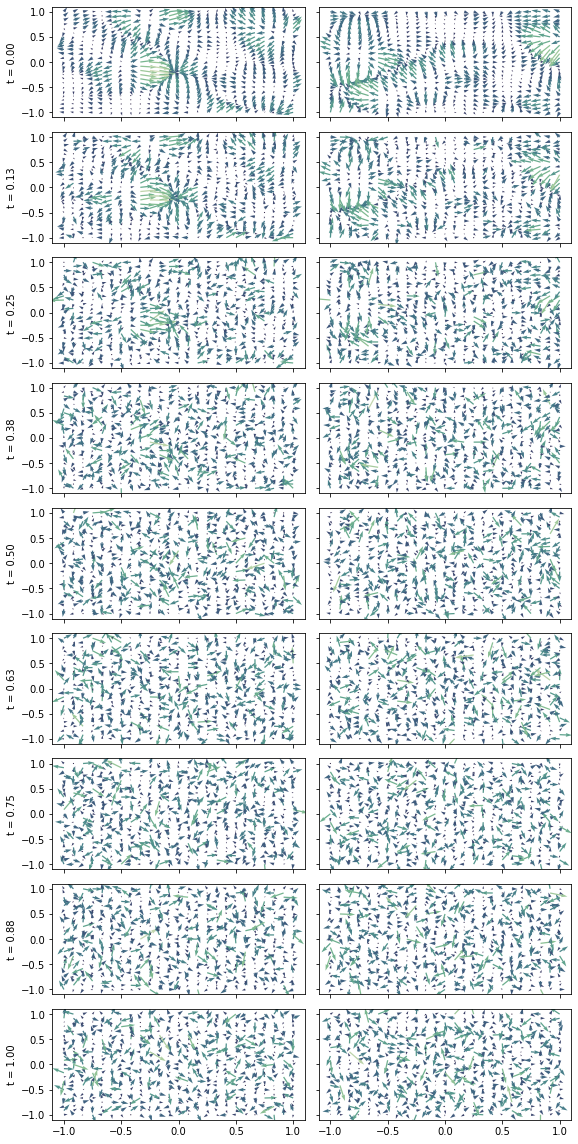

In [8]:
import seaborn as sns
import matplotlib

norm = matplotlib.colors.Normalize()
cm = sns.cubehelix_palette(start=0.5, rot=-0.75, as_cmap=True, reverse=True)

ts, ys = out
plot_num_timesteps = ys.shape[1]
fig, axes = plt.subplots(
    plot_num_timesteps, num_samples, sharex=True, sharey=True, figsize=(8, 16)
)
for j in range(plot_num_timesteps):
    for i in range(num_samples):
        if x.shape[-1] == 1:
            for o in range(output_dim):
                axes[j, i].plot(x, ys[i, j, :, o], '-', ms=2)
        elif x.shape[-1] == 2:
            y_norm = jnp.linalg.norm(ys[i, j], axis=-1)
            axes[j, i].quiver(
                x[:, 0],
                x[:, 1],
                ys[i, j, :, 0],
                ys[i, j, :, 1],
                color=cm(norm(y_norm)),
                scale=50,
                width=0.005,
            )  

        axes[j, 0].set_ylabel(f"t = {ts[0, j]:.2f}")

plt.tight_layout()

In [9]:
@check_shapes(
    "t: []",
    "x: [N, D]",
    "y0: [N, P] if y0 is not None",
    "return[0]: [N, P]",
    "return[1]: [N, N, P, P]",
)
def pt(x, t, y0=None):
    """Marginal of OU process at time t. When passing y0 this returns the conditional marginal."""
    # TODO: change if limiting processes have different mean functions.
    mean0 = mean1 = mean_function
    mean_coef = jnp.exp(-0.5 * beta_schedule.B(t))

    mean1 = eval_meanfunction(mean1, x)  # [N, P]

    if y0 is None:
        mean0 = eval_meanfunction(mean0, x)  # [N, P]
        mean = mean_coef * mean0 + (1.0 - mean_coef) * mean1
    else:
        mean = mean_coef * y0 + (1.0 - mean_coef) * mean1
    
    k1xx = gram(k1, x)

    if y0 is None:
        k0xx = gram(k0, x)
        cov = k1xx + jnp.exp(-beta_schedule.B(t)) * (k0xx - k1xx)
    else:
        cov = (1.0 -  jnp.exp(-beta_schedule.B(t))) * k1xx
    
    return mean, cov


@check_shapes(
    "t: []",
    "x: [N, D]",
    "y0: [N, P] if y0 is not None",
    "return: [N, P]",
)
def sample_pt(key, x, t, y0=None):
    "Marginal distribution p(yt) if y0 is passed p(yt | xt)"
    mean, cov = pt(x, t, y0)
    n, p = mean.shape[0], mean.shape[1]
    mean = rearrange(mean, "n p -> (n p) 1", n=n, p=p)
    cov = rearrange(cov, 'n1 n2 p1 p2 -> (n1 p1) (n2 p2)', n1=n, n2=n, p1=p, p2=p)
    s = ndp.misc.sample_mvn(key, mean, cov)  # [np, 1]
    return rearrange(s, '(n p) 1 -> n p', n=n, p=p)

In [10]:

if x.shape[-1] == 1:
    fig, axes = plt.subplots(plot_num_timesteps, num_samples, sharex=True, sharey=True, figsize=(8, 7))

    for t_index in range(plot_num_timesteps):
        for sample_index in range(num_samples):
            t = ts[0, t_index]
            mean, cov = pt(x, t, ys[sample_index, 0])
            for o in range(output_dim):
                covd = cov[..., o, o]
                std = jnp.diag(covd).reshape(-1,1)**0.5
                axes[t_index, sample_index].plot(x, ys[sample_index, t_index, :, o], 'o-', ms=2)
                axes[t_index, sample_index].plot(x, mean[..., o:o+1], 'k--', alpha=.5)
                lo, up = (v.flatten() for v in (mean[..., o:o+1] - 2 * std, mean[..., o:o+1] + 2 * std))
                axes[t_index, sample_index].fill_between(x.flatten(), lo, up, alpha=.1, color='k')
            axes[t_index, 0].set_ylabel(f"t = {t:.2f}")
            axes[t_index, sample_index].set_ylim(-2.5, 2.5)

    plt.tight_layout()

In [11]:

solve_lower_triangular = partial(jax.scipy.linalg.solve_triangular, lower=True)  # L⁻¹ x
solve_upper_triangular = partial(jax.scipy.linalg.solve_triangular, lower=False)  # U⁻¹ x

from check_shapes import check_shape as cs


@check_shapes("yt: [NP, 1]", "x: [N, D]", "t: []", "return: [NP, 1]",)
def preconditioned_score(yt, x, t):
    "Exact marginal score in Gaussian setting"
    mu_t, Sigma_t = pt(x, t)
    n, p = mu_t.shape[0], mu_t.shape[1]
    mu_t = rearrange(mu_t, "n p -> (n p) 1", n=n, p=p)
    Sigma_t = rearrange(Sigma_t, 'n1 n2 p1 p2 -> (n1 p1) (n2 p2)', n1=n, n2=n, p1=p, p2=p)
    Lt = jnp.linalg.cholesky(Sigma_t + JITTER * jnp.eye(len(Sigma_t)))
    b = yt - mu_t
    A = solve_upper_triangular(jnp.transpose(Lt), solve_lower_triangular(Lt, b))
    k1xx = cs(gram(k1, x), "[N, N, P, P]")
    k1xx = rearrange(k1xx, 'n1 n2 p1 p2 -> (n1 p1) (n2 p2)', n1=n, n2=n, p1=p, p2=p)
    return cs(- k1xx @ A, "[NP, 1]")


@check_shapes("t: []", "yt: [NP, 1]", "x: [N, D]", "return: [NP, 1]",)
def reverse_drift_ode(t, yt, x):
    return  drift(t, yt, x) - 0.5 * beta_schedule(t) * preconditioned_score(yt, x, t) # [N, 1]

# def reverse_drift_sde(t, yt, x):
#     return  drift(t, yt, x) - beta_schedule(t) * preconditioned_score(yt, x, t) # [N, 1]

@check_shapes("yT: [N, P]", "return[0]: [T]", "return[1]: [T, N, P]")
def reverse_solve(key, yT, prob_flow: bool = True):
    n, p = yT.shape[0], yT.shape[1]
    yT = rearrange(yT, 'n p -> (n p) 1')
    t0, t1 = beta_schedule.t0, beta_schedule.t1
    ts = t1 + (t0 - t1) * (jnp.exp(jnp.linspace(t0, t1, 9)) - jnp.exp(t0)) / (jnp.exp(t1) - jnp.exp(t0))
    ts = jnp.linspace(t0, t1, 9)[::-1]
    saveat = dfx.SaveAt(ts=ts)
    # reverse time, solve from t1 to t0
    if prob_flow:
        terms = dfx.ODETerm(reverse_drift_ode)
    else:
        pass
        # drift = dfx.ODETerm(reverse_drift_sde)
        # shape = jax.ShapeDtypeStruct(yT.shape, yT.dtype)
        # bm = dfx.VirtualBrownianTree(t0=t1, t1=t0, tol=1e-3 / 2., shape=shape, key=key)
        # terms = dfx.MultiTerm(drift, MatVecControlTerm(diffusion, bm))

    sol = dfx.diffeqsolve(terms, solver=dfx.Euler(), t0=t1, t1=t0, dt0=-1e-3/2., y0=yT, saveat=saveat, args=x, adjoint=dfx.NoAdjoint())
    return (
        sol.ts, rearrange(sol.ys, "t (n p) 1 -> t n p", t=len(ts), n=n, p=p)
    )


key = jax.random.PRNGKey(0)
key, *subkeys = jax.random.split(key, 1+num_samples)
rev_out = jax.vmap(reverse_solve)(jnp.stack(subkeys), ys[:, -1])

key, *subkeys = jax.random.split(key, 1+num_samples)
rev_out2 = jax.vmap(reverse_solve)(jnp.stack(subkeys), ys[:, -1])

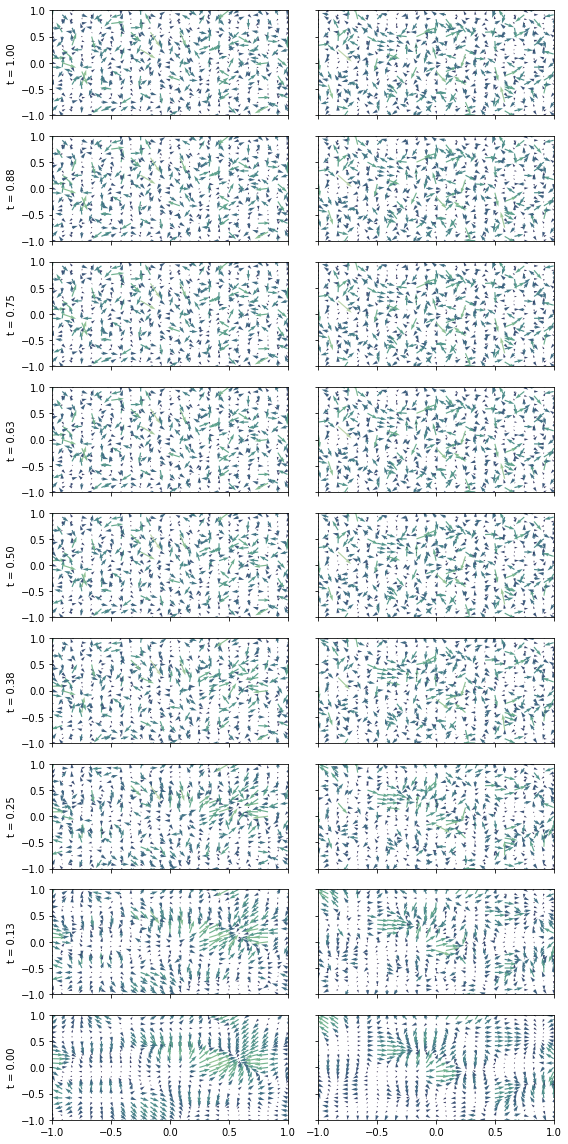

In [12]:
fig, axes = plt.subplots(plot_num_timesteps, num_samples, sharex=True, sharey=True, figsize=(8, 16))
for t in range(plot_num_timesteps):
    for i in range(num_samples):
        if x.shape[-1] == 1:
            for o in range(output_dim):
                axes[t, i].plot(x, rev_out[1][i, t, :, o], '-', ms=2)
                axes[t, i].plot(x, rev_out2[1][i, t, :, o], ':', ms=2)
            axes[t, i].set_ylim(-2.5, 2.5)
        elif x.shape[-1] == 2 and output_dim == 2:
            y_norm = jnp.linalg.norm(rev_out[1][i, t], axis=-1)
            axes[t, i].quiver(
                x[:, 0],
                x[:, 1],
                rev_out[1][i, t, :, 0],
                rev_out[1][i, t, :, 1],
                color=cm(norm(y_norm)),
                scale=50,
                width=0.005,
            )  
            axes[t, i].set_ylim(-1, 1)
            axes[t, i].set_xlim(-1, 1)

        axes[t, 0].set_ylabel(f"t = {rev_out[0][0, t]:.2f}")
plt.tight_layout()

In [13]:

@check_shapes(
    "x_context: [num_context, D]",
    "y_context: [num_context, P]",
    "x_target: [num_target, D]",
    "return: [num_target, P]",
)
def conditional_sample(key, x_context, y_context, x_target, num_steps: int, num_inner_steps: int):
    num_context = len(x_context)
    num_target = len(x_target)
    p = y_context.shape[1]

    # y_context = rearrange(y_context, "n p -> (n p) 1", n=num_context, p=p)

    shape_augmented_state = [(num_context + num_target) * p, 1]

    t0 = beta_schedule.t0
    t1 = beta_schedule.t1
    ts = jnp.linspace(t1, t0, num_steps, endpoint=True)
    dt = ts[0] - ts[1]

    solver = dfx.Euler()
    # reverse ODE:
    ode_terms_reverse = dfx.ODETerm(reverse_drift_ode)

    # reverse SDE:
    # shape = jax.ShapeDtypeStruct(shape_augmented_state, y_context.dtype)
    # key, subkey = jax.random.split(key)
    # bm = dfx.VirtualBrownianTree(t0=t1, t1=t0, tol=dt, shape=shape, key=subkey)
    # ode_terms_reverse = dfx.MultiTerm(dfx.ODETerm(reverse_drift_sde), dfx.ControlTerm(diffusion, bm))

    # forward SDE:
    shape = jax.ShapeDtypeStruct(shape_augmented_state, y_context.dtype)
    key, subkey = jax.random.split(key)
    bm = dfx.VirtualBrownianTree(t0=t0, t1=t1, tol=dt, shape=shape, key=subkey)
    sde_terms_forward = dfx.MultiTerm(dfx.ODETerm(drift), MatVecControlTerm(diffusion, bm))

    def inner_loop(key, yt, t):
        yt_context = sample_pt(key, x_context, t, y_context)
        yt_context = rearrange(yt_context, "n p -> (n p) 1", n=num_context, p=p)
        yt_augmented = jnp.concatenate([yt_context, yt], axis=0)
        x_augmented = jnp.concatenate([x_context, x_target], axis=0)

        # reverse step
        yt_m_dt, *_ = solver.step(ode_terms_reverse, t, t - dt, yt_augmented, x_augmented, None, made_jump=False)

        # forward step
        yt, *_ = solver.step(sde_terms_forward, t - dt, t, yt_m_dt, x_augmented, None, made_jump=False)

        # strip context from augmented state
        return yt[num_context * p:], yt_m_dt[num_context * p:]

    def outer_loop(key, yt, t):
        _, yt_m_dt = jax.lax.scan(lambda yt, key: inner_loop(key, yt, t), yt, jax.random.split(key, num_inner_steps))
        yt = yt_m_dt[-1]
        return yt, yt


    key, subkey = jax.random.split(key)
    # yT = sample_pt(subkey, x_test, 1.0)
    yT = cs(sample_gp(subkey, k1, mean_function, x_target, num_samples=None), "[N, P]")
    yT = rearrange(yT, "n p -> (n p) 1", n=num_target, p=p)

    xs = (ts[:-1], jax.random.split(key, len(ts) - 1))
    y0, _ = jax.lax.scan(lambda yt, x: outer_loop(x[1], yt, x[0]), yT, xs)
    return rearrange(y0, "(n p) 1 -> n p", n=num_target, p=p)


if x.shape[-1] == 1:
    x_known = jnp.reshape(jnp.asarray([[-0.2, 0.2, 0.6]]), (-1, 1))
elif x.shape[-1] == 2:
    x_known = jnp.zeros((1, 2)) + 1.e-2

if x.shape[-1] == 1 and output_dim == 1:
    y_known = jnp.reshape(jnp.asarray([[0.0, -1.0, 0.0]]), (len(x_known), output_dim))
elif x.shape[-1] == 1 and output_dim == 2:
    y_known = jnp.reshape(jnp.asarray([[0.0, -1.0, 3.0, .2, 1.1, 0.]]), (len(x_known), output_dim))
elif x.shape[-1] == 2 and output_dim == 2:
    y_known = jnp.reshape(jnp.asarray([[8., 0]]), (1, 2))


print(x_known.shape)
print(y_known.shape)

if x.shape[-1] == 1:
    x_test = jnp.linspace(-1, 1, 101)[:, None]
elif x.shape[-1] == 2:
    x_test = get_2d_grid(21)

key = jax.random.PRNGKey(0)
num_samples = 100 if x.shape[-1] == 1 else 9
samples = jax.vmap(lambda key: conditional_sample(key, x_known, y_known, x_test, 100, 1))(jax.random.split(key, num_samples))

(1, 2)
(1, 2)


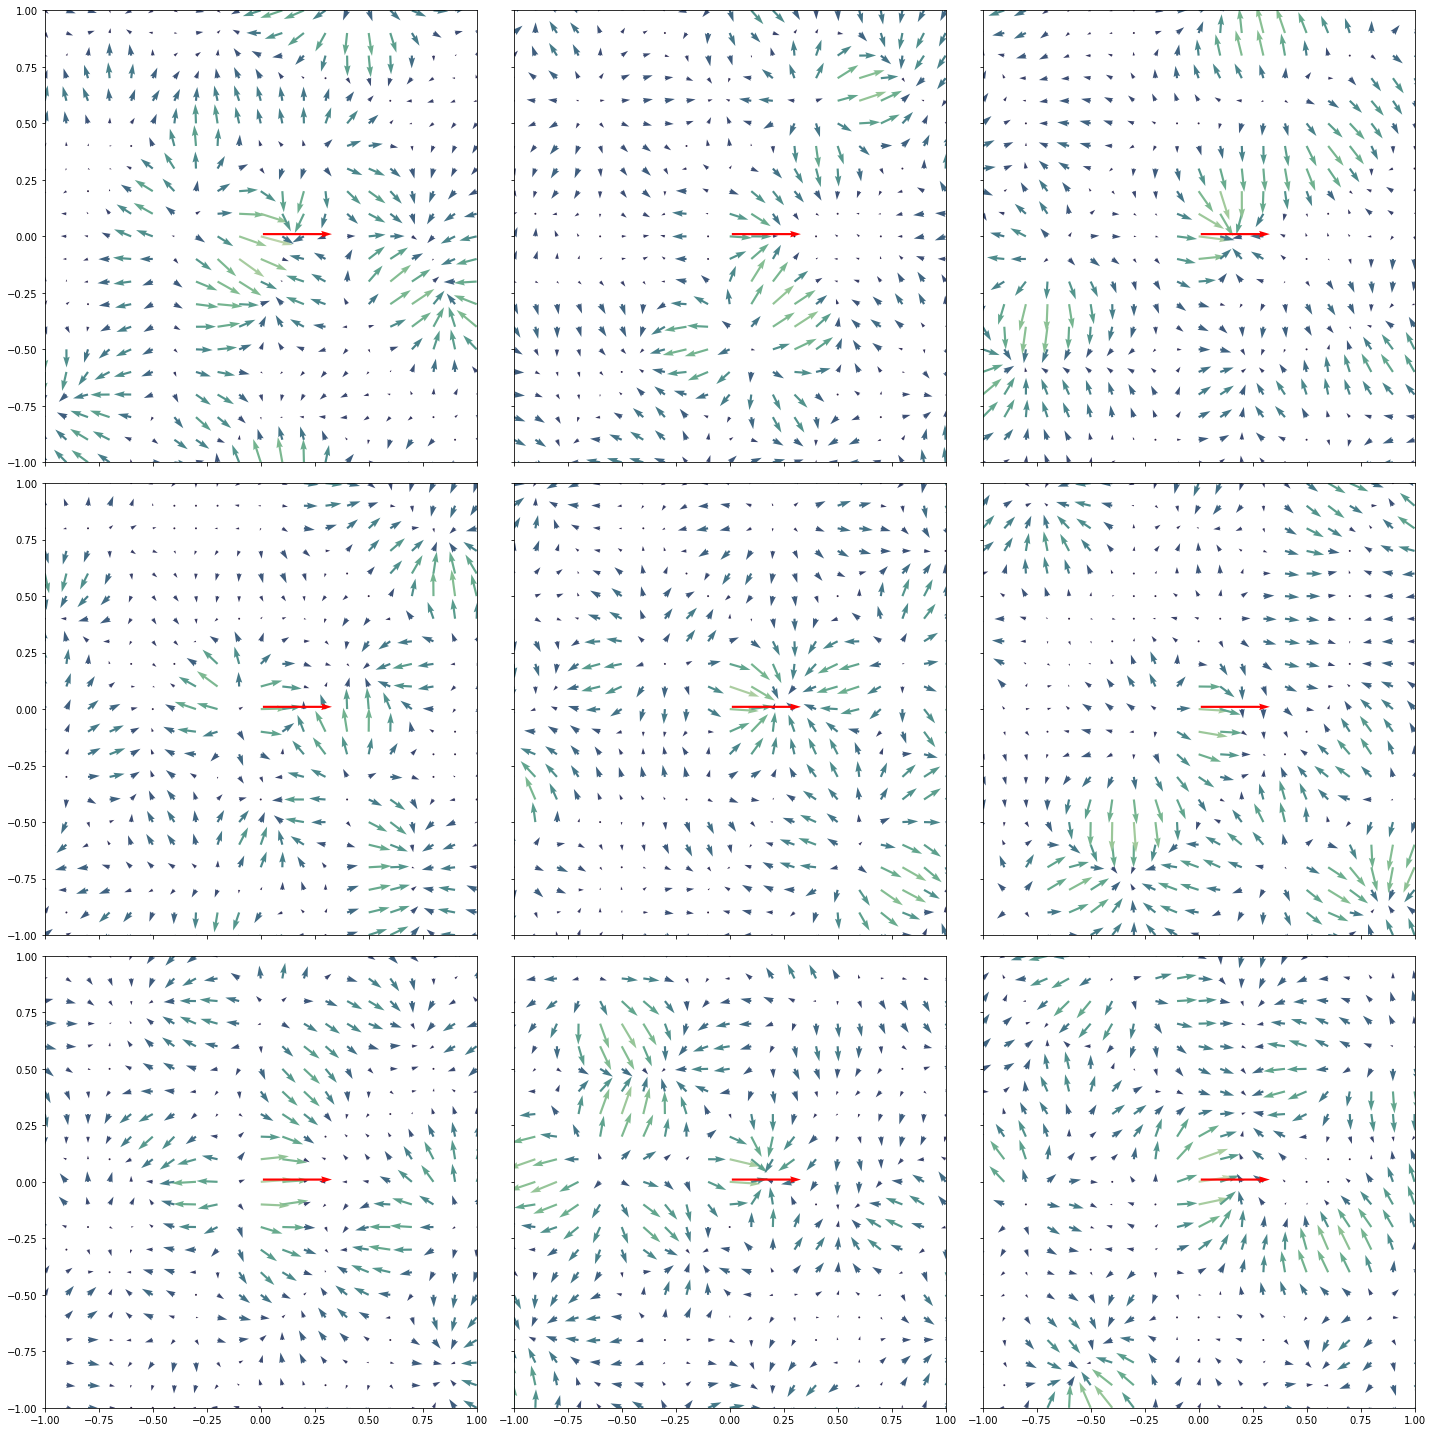

In [14]:
if x.shape[-1] == 1:
    plt.figure()
    for o in range(output_dim):
        plt.plot(x_test, samples[..., o].T, f"C{o}-", alpha=.2)
        plt.plot(x_known, y_known[:, o], f"kx")


elif x.shape[-1] == 2 and output_dim == 2:
    fig, axes = plt.subplots(3, 3, figsize=(20, 20), sharex=True, sharey=True)

    for i, ax in enumerate(np.array(axes).ravel()):
        s_norm = jnp.linalg.norm(samples[i], axis=-1)
        ax.quiver(
            x_test[:, 0],
            x_test[:, 1],
            samples[i, :, 0],
            samples[i, :, 1],
            color=cm(norm(s_norm)),
            scale=50,
            width=0.005,
        )  
        ax.quiver(
            x_known[:, 0],
            x_known[:, 1],
            y_known[:, 0],
            y_known[:, 1],
            color='r',
            scale=50,
            width=0.005,
        )  
        ax.set_ylim(-1, 1)
        ax.set_xlim(-1, 1)


plt.tight_layout()
plt.savefig('conditional_divfree.png', dpi=300, facecolor='white', edgecolor='none')